In [303]:
from radio_z import hifit, saxdata, hiprofile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
%load_ext autoreload
%matplotlib nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Read in the catalogue with the SAX parameters from an HDF5 file

In [174]:
%autoreload

In [164]:
rt = '/home/michelle/Project/HI_fit/sub_z/cats/'
#name = 'snr10_cat'
name = 'uniform_snr_200'
cat_name = rt+name+'.h5'

In [165]:
surv = saxdata.Survey('ska1_band1')
cat = saxdata.SaxCatalogue(cat_name)
#cat_df = cat.get_data()
bigdata_rt = '/home/michelle/BigData/HI_output/'
rt = bigdata_rt+'cats_n_chains/uniform_snr_200/'

Create the mock HI data from the SAX parameters for the whole catalogue

In [168]:
make_new_data = True
data_maker = saxdata.DataFromCatalogue()

if make_new_data:
    cat.write_to_disk(rt)
    data_maker.create_from_cat(surv, filepath=rt)
ids = cat.get_ids()

In [328]:
ind = 'ID66232966'
#ind = ids[50]
fl = rt+ind+'.hdf5'
params=pd.read_hdf(fl,'parameters')
data=pd.read_hdf(fl,'data')
summary=pd.read_hdf(fl,'summary')
print(ind)
print(params.ska1_band1_snr.iloc[0])
fit_params=summary['MAP'].as_matrix()[:-1]
print(params.v0)
print(summary)

ID66232966
8.4189063099
32965   -94223.581566
Name: v0, dtype: float64
                     Mean        Median           MAP           16p  \
v0          -94052.175990 -94026.611437 -94026.783704 -94030.503879   
w_obs_20       397.513361    444.712514    419.919339    421.078363   
w_obs_50       369.929699    420.372057    419.526041    395.265668   
w_obs_peak     317.655692    362.919192    360.437973    352.616307   
psi_obs_max      0.000585      0.000538      0.000512      0.000433   
psi_obs_0        0.000083      0.000031      0.000030      0.000021   
z                0.456680      0.456499      0.456500      0.456471   

                      84p          True  
v0          -94022.639804 -94223.581566  
w_obs_20       467.940214     43.500000  
w_obs_50       434.342623     33.400000  
w_obs_peak     373.402642     13.900000  
psi_obs_max      0.000717      0.000863  
psi_obs_0        0.000057      0.000772  
z                0.456526      0.457893  


Each object is stored in a separate dataframe in the HDF5 file. We can plot an example profile to have a look.

<IPython.core.display.Javascript object>


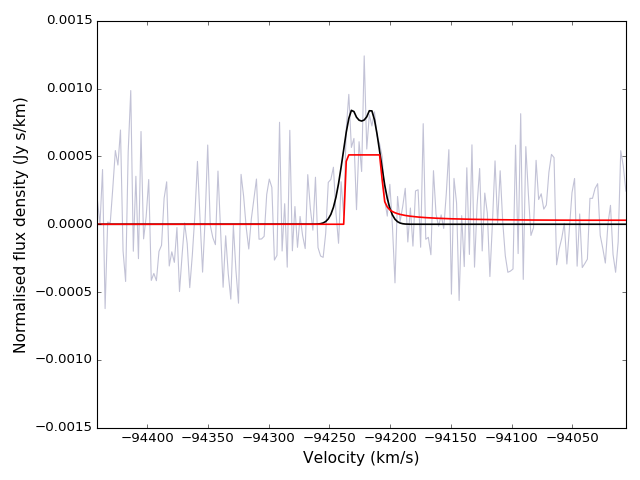

In [330]:
plt.figure()
data_maker.plot_profile(data, plot_model=True, model_params=cat.get_params(params, ind), 
                        plot_fit=True, fit_params=fit_params, zoom=True)

Fit a single object

In [110]:
%autoreload

In [332]:
fd = hifit.FitData(filename=fl)

In [333]:
fd.fit(chain_name=bigdata_rt+'temp/'+ind+'-', save_to_hdf=True, delete_files=False, n_live_points=1000)

Time taken 29.027544391155242 minutes


<IPython.core.display.Javascript object>


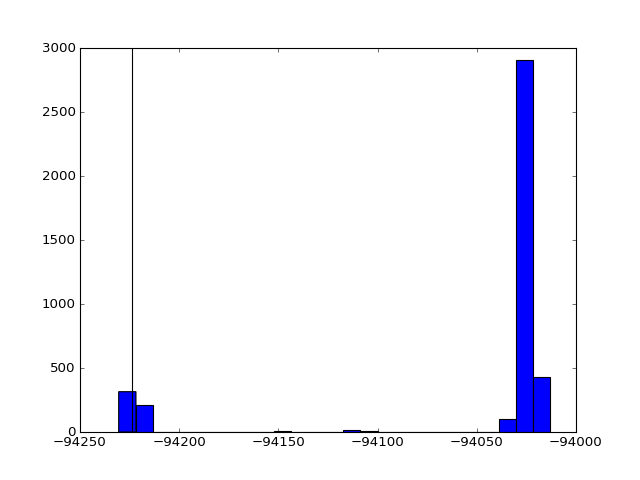

In [331]:
chain=pd.read_hdf(fl,'chain')
ev = pd.read_hdf(fl, 'evidence')
params = pd.read_hdf(fl, 'parameters')
plt.figure()
blah=plt.hist(chain.v0,25)
plt.plot([params.v0.iloc[0], params.v0.iloc[0]], plt.gca().get_ylim(),'k')

In [92]:
ev

,ln(evidence),uncertainty,Bayes factor
0,-34836.837847,0.220474,-1.323671


In [84]:
params

,v0,w_obs_20,w_obs_50,w_obs_peak,psi_obs_max,psi_obs_0
17049,-101943.985798,60.6,50.5,30.8,0.000803,0.000343


This object allows us to fit the whole catalogue, in parallel if requested

In [189]:
fc = hifit.FitCatalogue(rt)

In [285]:
run_multinest = False #In case we've already run these

In [191]:
if run_multinest:
    fc.fit_all(nprocesses=8, output_dir=bigdata_rt+'temp',save_to_hdf=True, delete_files=True)

Fitting object ID78105238
Fitting object ID59807857
Fitting object ID217782840
Fitting object ID184248873
Fitting object ID54409736
Fitting object ID71900564
Fitting object ID54518889
Fitting object ID65294522
Deleting files
Time taken 8.523706761995951 minutes
Fitting object ID54167464
Deleting files
Time taken 9.019851398468017 minutes
Fitting object ID54290136
Deleting files
Time taken 11.328619158267974 minutes
Fitting object ID65582848
Deleting files
Time taken 12.162389326095582 minutes
Fitting object ID49557813
Deleting files
Time taken 15.18105481863022 minutes
Fitting object ID49558032
Deleting files
Time taken 22.393951765696208 minutes
Fitting object ID78023014
Deleting files
Time taken 18.584374233086905 minutes
Fitting object ID72596820
Deleting files
Time taken 33.14057511488597 minutes
Fitting object ID59813587
Deleting files
Time taken 34.63148579200109 minutes
Fitting object ID65285561
Deleting files
Time taken 10.267814024289448 minutes
Fitting object ID59699020
Delet

You can use the ChainAnalyser object to run useful analyses, such as getting the best fit estimates of the parameters, the errors (in terms of 16% and 84% marginals) and P(z) as a histogram. Here we print out the bias for each parameter for each object, measured in n sigma.

In [134]:
%autoreload

In [311]:
def get_snr(fl):
    data = pd.read_hdf(fl, 'data')
    ests = pd.read_hdf(f, 'summary')
    prms = ests['True'].as_matrix()[:-1]
    lp = hiprofile.LineProfile(*prms)
    psi_fit = lp.get_line_profile(data.v.as_matrix())
    return abs(psi_fit/data.psi_err).max()

In [192]:
fls = glob.glob(rt+'*')

In [193]:
for f in fls:
    An = hifit.ChainAnalyser(f)
    prms = pd.read_hdf(f,'parameters')[An.param_names[:-1]]
    prms = prms.as_matrix()[0]
    An.parameter_estimates(true_params=prms, save_to_file=True)

In [312]:
param ='z'
plot_df = pd.DataFrame(data=[], columns=['id', 'snr', 'true_snr', param+'_true', param+'_mean', param+'_err', 'bayes'])
for f in fls:
    ests = pd.read_hdf(f, 'summary')
    prms = pd.read_hdf(f, 'parameters')
    ev = pd.read_hdf(f, 'evidence')
    ind = prms.id.iloc[0]
    snr = prms.ska1_band1_snr.iloc[0]
    true_param = ests.loc[param,'True']
    mean_param = ests.loc[param,'MAP']
    bayes_fact = ev['Bayes factor'].iloc[0]
    sig = ((ests.loc[param,'84p']-ests.loc[param,'Mean'])+(ests.loc[param,'Mean'])-ests.loc[param,'16p'])/2
    true_snr = get_snr(f)
    plot_df.loc[len(plot_df)] = [ind, snr, true_snr, true_param, mean_param, sig, bayes_fact]

<IPython.core.display.Javascript object>


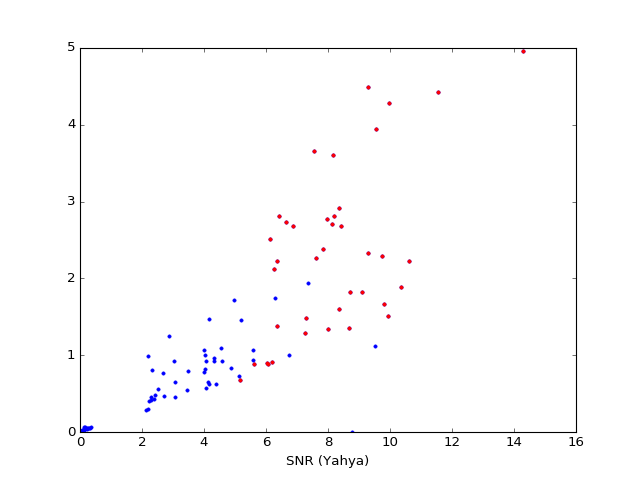

In [315]:
plt.figure()
plt.plot(plot_df.snr, plot_df.true_snr, '.')
plt.plot(plot_df.snr[mask], plot_df.true_snr[mask], 'r.')
plt.xlabel('SNR (Yahya)')

<IPython.core.display.Javascript object>


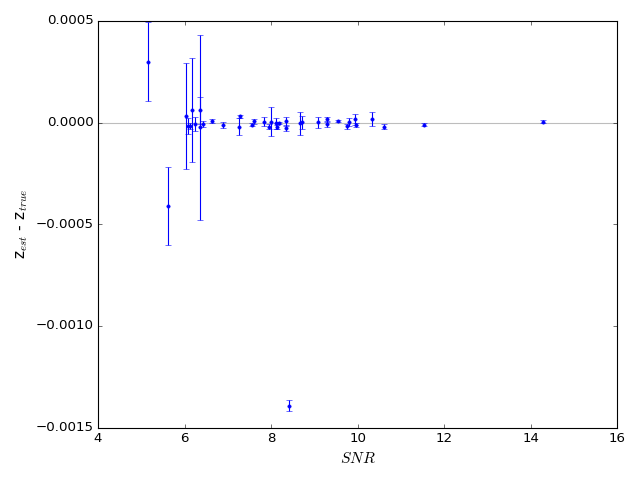

In [327]:
plt.figure()
mask = plot_df.bayes>5
#mask = [True]*len(plot_df)
x=plot_df.snr[mask].as_matrix()
y=plot_df.z_mean[mask]-plot_df.z_true[mask]
y=y.as_matrix()
yerr=plot_df.z_err[mask].as_matrix()
plt.errorbar(x, y, yerr=yerr, linestyle='none', marker='.')
plt.plot(plt.gca().get_xlim(),[0,0],c='#bdbdbd',zorder=0)
fntsz = 14
plt.xlabel('$SNR$', fontsize=fntsz)
plt.ylabel('z$_{est}$ - z$_{true}$', fontsize=fntsz)
plt.tight_layout()

<IPython.core.display.Javascript object>


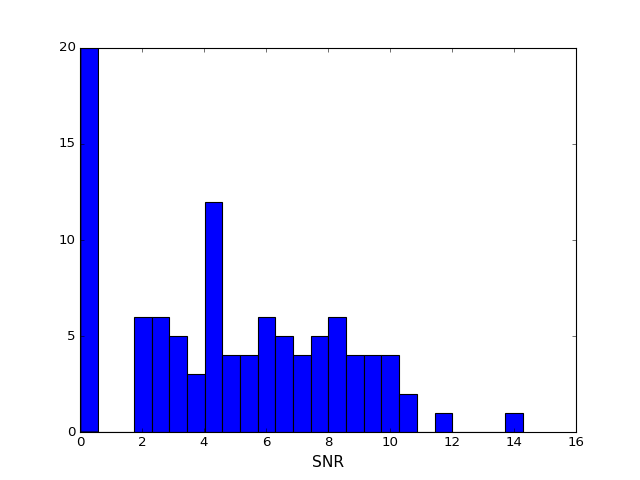

In [234]:
plt.figure()
plt.hist(plot_df.snr, 25)
plt.xlabel('SNR', fontsize=fntsz)

In [251]:
plot_df[plot_df.snr>8]

,id,snr,z_true,z_mean,z_err,bayes
1,ID49558032,14.289201,0.354826,0.354830,0.000006,157.102505
8,ID54409736,8.003018,0.379691,0.379696,0.000071,17.344953
10,ID59239024,9.558943,0.402088,0.402095,0.000004,73.738881
12,ID65294522,9.501378,0.475802,0.866566,0.657143,-3.382150
16,ID59807857,8.349460,0.424424,0.424397,0.000013,21.860141
21,ID54290136,9.800507,0.377451,0.377454,0.000020,48.905322
25,ID54167464,8.354442,0.372750,0.372756,0.000022,26.829610
32,ID66240543,8.114576,0.458523,0.458519,0.000026,37.518952
53,ID72038190,11.541968,0.486762,0.486751,0.000008,137.219503
56,ID72038292,9.295545,0.487687,0.487703,0.000011,85.477960


In [196]:
(plot_df.v0_mean-plot_df.v0_true)

-10503.803948215511

# Scratch

In [272]:
%autoreload

In [339]:
np.array_split(range(10),0)

ValueError: number sections must be larger than 0.

<IPython.core.display.Javascript object>


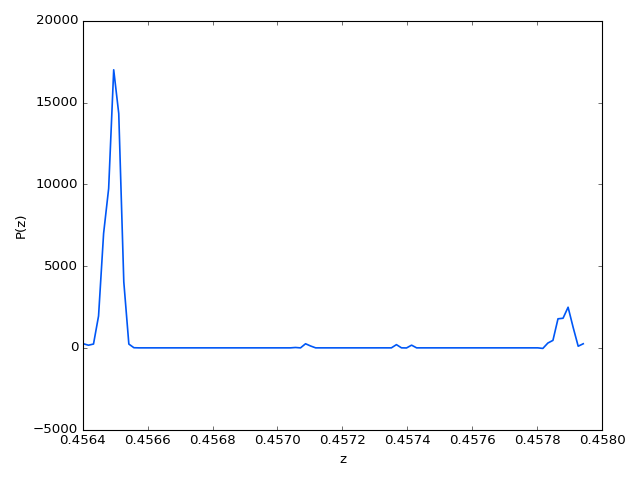

/home/michelle/anaconda2/envs/py3/lib/python3.5/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: 'p(z)'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


In [278]:
An = hifit.ChainAnalyser(fl)
plt.figure()
An.plot_p_of_z(delta_z=0.000001, smooth=True)

In [109]:
prms.columns

Index(['id', 'galaxyid', 'box', 'ra', 'decl', 'distance', 'zapparent',
       'hubbletype', 'himass', 'h2mass', 'hiintflux', 'cointflux_1',
       'cointflux_2', 'cointflux_3', 'cointflux_4', 'cointflux_5',
       'cointflux_6', 'cointflux_7', 'cointflux_8', 'cointflux_9',
       'cointflux_10', 'diskpositionangle', 'diskinclinaction',
       'gassscaleradius', 'rmolc', 'hiaxisratio', 'himajoraxis_msunpc',
       'himajoraxis_max', 'himajoraxis_50max', 'himajoraxis_10max',
       'himajoraxis_halfmass', 'h2axisratio', 'h2majoraxis_msunpc',
       'h2majoraxis_50max', 'h2majoraxis_10max', 'h2majoraxis_halfmass',
       'balancemajoraxis', 'hilumcenter', 'hilumpeak', 'hiwidthpeak',
       'hiwidth50', 'hiwidth20', 'columcenter', 'columpeak', 'cowidthpeak',
       'cowidth50', 'cowidth20', 'cofillingfactor', 'ska1_band1_snr',
       'ska1_band2_snr', 'v0', 'w_obs_20', 'w_obs_50', 'w_obs_peak',
       'psi_obs_max', 'psi_obs_0'],
      dtype='object')

In [67]:
c=np.load('/home/michelle/BigData/HI_output/'+ind+'-post_equal_weights.dat.npy')

<IPython.core.display.Javascript object>


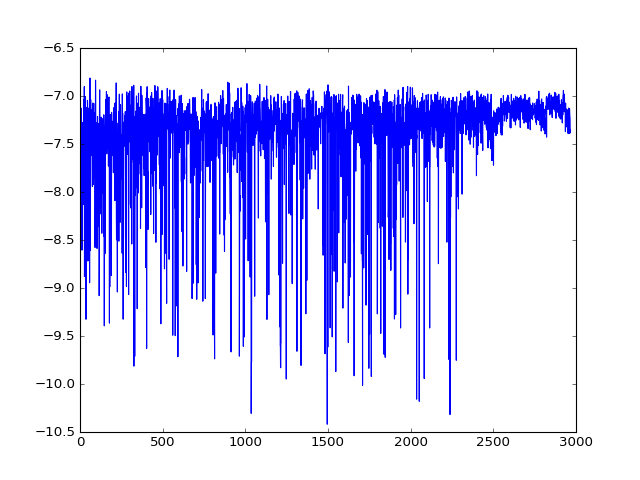

In [68]:
plt.figure()
plt.plot(c[:,5])
#a = plt.hist(c[:,5],25)

In [53]:
import pandas as pd

In [57]:
d = pd.read_csv('/home/michelle/Project/HI_fit/sub_z/91a09e81829d518c605c4601c9e52a7797d5e545.result')

In [71]:
d.hilumcenter.max()

0.0499

In [72]:
np.exp(-1)

0.36787944117144233

In [153]:
import os
pth='/home/michelle/BigData/HI_output/'
fls=os.listdir(pth)
for f in fls:
    if f[0] == ':':
        os.system('mv '+pth+f+' '+pth+f[1:])

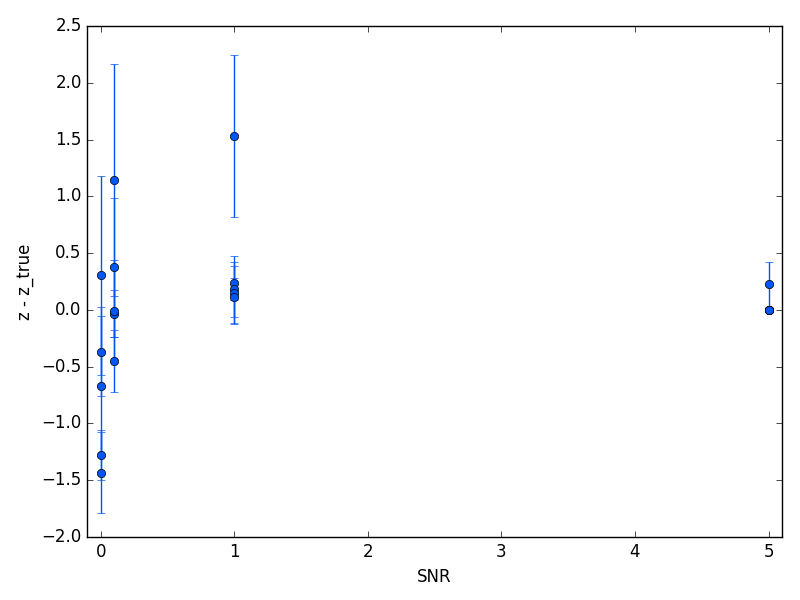

In [90]:
from IPython.display import Image
Image(filename='/home/michelle/BigData/HI_output/snr_analysis/SNR_vs_z.png') 

In [284]:
50000*10/60/12/12

57.870370370370374